In [1]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler,AutoencoderKL
import torch
model_id = "runwayml/stable-diffusion-v1-5"
#model_id="stabilityai/stable-diffusion-2-1"
#stable_diffusion_txt2img = StableDiffusionPipeline.from_pretrained(model_id)


vae_path='/tmp3/jimmyliu/HiDDeN_experiment/finetune_SD/runs/test-clean 2023.05.27--19-45-59/checkpoints/vae'

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
tmpe_vae=AutoencoderKL.from_pretrained(vae_path)
pipe.vae.decoder=tmpe_vae.decoder
pipe.vae.post_quant_conv=tmpe_vae.post_quant_conv

/home/master/10/jimmyliu/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/master/10/jimmyliu/miniconda3/envs/ldm/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
  warnings.warn("WARNING: failed to get cudart_version from onnxruntime build info.")
Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 25277.04it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [2]:
import os
import time
import pprint
import argparse
import torch
import numpy as np
import pickle
import utils
import csv

from model.hidden import Hidden
from noise_layers.noiser import Noiser
from average_meter import AverageMeter
from noise_argparser import NoiseArgParser

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
current_run="/tmp3/jimmyliu/HiDDeN_experiment/finetune_SD/runs/test-clean 2023.05.27--19-45-59"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
options_file = os.path.join(current_run, 'options-and-config.pickle')
train_options, hidden_config, _ = utils.load_options(options_file)
#train_options.train_folder = os.path.join(data_dir, 'val')
#train_options.validation_folder = os.path.join(data_dir, 'train')
#train_options.batch_size = batch_size
noise_config=[]

In [4]:
noiser = Noiser(noise_config,device)
model = Hidden(hidden_config, device, noiser, tb_logger=None,train_options=train_options)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 6738.20it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [5]:
checkpoint, chpt_file_name = utils.load_checkpoint('/tmp3/jimmyliu/HiDDeN_experiment/finetune_SD/runs/test-clean 2023.05.27--19-45-59/checkpoints/test-clean--epoch-1.pyt')
utils.load_wm_decoder(model, checkpoint)
wm_decoder=model.encoder_decoder.decoder
wm_decoder.eval()

Decoder(
  (layers): Sequential(
    (0): ConvBNRelu(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNRelu(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBNRelu(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNRelu(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05,

In [6]:
height=512
width=512
num_images=4
generator = torch.Generator(device=device)

latents = None
seeds = [6287617534658327,4149908532943684, 8054710645887470, 5125284379682575]
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    #seed = generator.seed()
    #seeds.append(seed)
    generator = generator.manual_seed(seeds[_])
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (4, 4, 64, 64) in this case
latents.shape

def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy

In [7]:
pipe=pipe.to(device)

In [8]:
prompt = "Emma Watson as a powerful mysterious sorceress, casting lightning magic, detailed clothing, digital painting, hyperrealistic, fantasy, Surrealist, full body, by Stanley Artgerm Lau and Alphonse Mucha, artstation, highly detailed, sharp focus"
#temp = pipe(prompt=[prompt]*num_images,height=height,width=width,latents = latents)
temp = pipe(prompt=[prompt]*num_images,height=height,width=width,guidance_scale=3.0,generator = [generator.manual_seed(seeds[i]) for i in range (4)])

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


In [9]:
images=temp.images

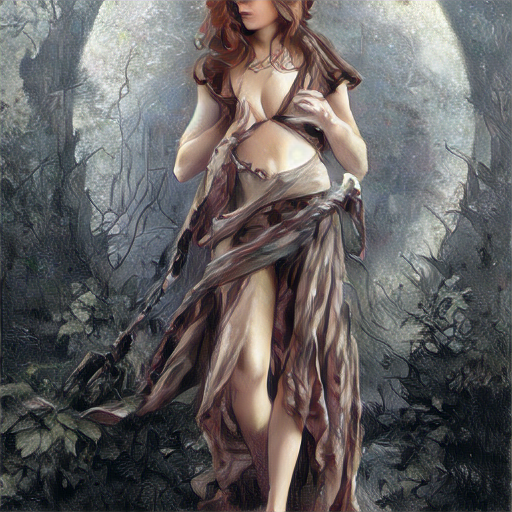

In [10]:
img=images[0]
img

In [11]:
from torchvision import  transforms
from noise_layers.jpeg_compression import rgb2yuv_tensor

In [12]:
T=transforms.Compose([
            transforms.RandomCrop((512, 512), pad_if_needed=True),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

In [13]:
img=T(images[0])

In [14]:
print(img.shape)
img=img.unsqueeze(0)
print(img.shape)

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [15]:
yuv_img=rgb2yuv_tensor(img)

In [16]:
print(yuv_img.shape)

torch.Size([1, 3, 512, 512])


In [17]:
fix_message=torch.Tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,                                                                                                                                                                                                   
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,                                                                                                                                                                                                                 
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

In [19]:
ans=wm_decoder(yuv_img.to(device))
print(ans)

tensor([[ 1.0432e+00,  6.3251e-01,  9.6749e-01,  3.3211e-02,  7.1573e-01,
          6.0282e-01,  8.1258e-01,  5.9983e-02,  2.2087e-01, -4.0657e-03,
          1.2512e-01,  3.7243e-02,  1.8758e-01,  8.6879e-02,  8.7227e-01,
          8.9274e-01,  7.2241e-02, -1.9395e-01,  8.9964e-01,  9.5431e-01,
          3.7038e-01,  8.1784e-01,  9.9759e-02,  9.3708e-01,  8.3198e-01,
          3.9880e-01,  7.7483e-01, -1.7711e-01, -2.5923e-01,  8.6846e-01,
          6.4091e-01,  1.0589e+00,  1.2364e-01,  8.6723e-01,  1.0185e+00,
          9.9129e-01, -1.9929e-03,  8.0447e-01,  6.8362e-01,  8.7844e-01,
          8.2752e-01,  5.2965e-01,  6.6788e-01,  9.9822e-01,  1.0677e+00,
          5.9509e-01,  7.0827e-02,  3.2160e-04]], device='cuda:0')


In [20]:
decoded_rounded = ans.detach().cpu().numpy().round().clip(0, 1)

In [23]:
print(decoded_rounded)

[[1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1.
  1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]]


In [22]:
bitwise_avg_err = np.sum(np.abs(decoded_rounded - fix_message.detach().cpu().numpy())) / fix_message.shape[1]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 bitwise_avg_err = np.sum(np.abs(decoded_rounded - fix_message.detach().cpu().numpy())) /     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: tuple index out of range